In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [2]:

import os

num_skipped = 0
for folder_name in ("clear", "cloudy"):
    folder_path = os.path.join("Images/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [3]:

image_size = (16, 16) #(544, 512)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Kernels_16x16/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "Kernels_16x16/test",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 49650 files belonging to 2 classes.
Using 39720 files for training.
Using 9930 files for validation.
Found 16540 files belonging to 2 classes.


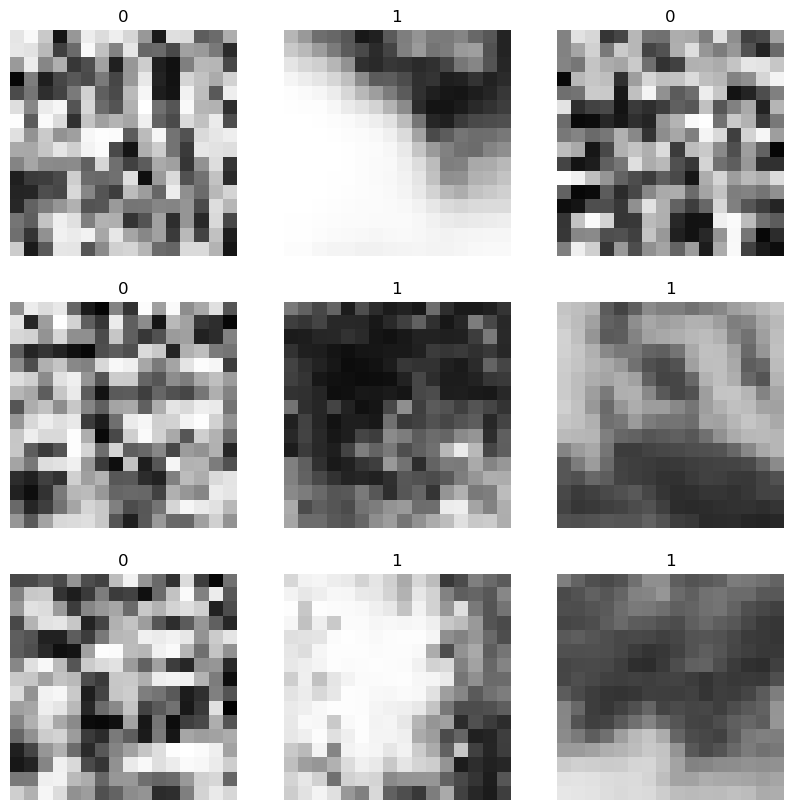

In [4]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [5]:
data_augmentation = keras.Sequential(
    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
    ]
)


In [6]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
#    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

#    for size in [256, 512, 728]:
#        x = layers.Activation("relu")(x)
#        x = layers.SeparableConv2D(size, 3, padding="same")(x)
#        x = layers.BatchNormalization()(x)

#        x = layers.Activation("relu")(x)
#        x = layers.SeparableConv2D(size, 3, padding="same")(x)
#        x = layers.BatchNormalization()(x)

#        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
#        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#            previous_block_activation
#        )
#        x = layers.add([x, residual])  # Add back residual
#        previous_block_activation = x  # Set aside next residual

#    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [8]:
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [10]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/10
311/311 [==============================] - 12s 35ms/step - loss: 0.2628 - accuracy: 0.9152 - val_loss: 0.5982 - val_accuracy: 0.5519
Epoch 2/10
311/311 [==============================] - 10s 31ms/step - loss: 0.1288 - accuracy: 0.9638 - val_loss: 0.1939 - val_accuracy: 0.9641
Epoch 3/10
311/311 [==============================] - 10s 31ms/step - loss: 0.0975 - accuracy: 0.9724 - val_loss: 0.0594 - val_accuracy: 0.9784
Epoch 4/10
311/311 [==============================] - 10s 31ms/step - loss: 0.0814 - accuracy: 0.9772 - val_loss: 0.0836 - val_accuracy: 0.9683
Epoch 5/10
311/311 [==============================] - 10s 31ms/step - loss: 0.0739 - accuracy: 0.9775 - val_loss: 0.0725 - val_accuracy: 0.9739
Epoch 6/10
311/311 [==============================] - 10s 31ms/step - loss: 0.0662 - accuracy: 0.9800 - val_loss: 0.0523 - val_accuracy: 0.9810
Epoch 7/10
311/311 [==============================] - 10s 31ms/step - loss: 0.0609 - accuracy: 0.9817 - val_loss: 0.0466 - val_accuracy:

# Identifying Outliers

In [11]:
import glob
outliers = []
count = 0
for i in glob.glob("Kernels_16x16/val/cloudy/*.png"):
    count += 1
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    clear_score = 100 * (1 - score)
    cloudy_score = 100 * score
    
    if (clear_score > 50):
        outliers.append(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.figure(figsize=(1, 1))
        #plt.imshow(img)
        #plt.title(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.axis("off")
print(count)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

In [ ]:

for i, item in enumerate(outliers):
    if(i < 10):
        filename = item.split(" ")[0]
        img = keras.utils.load_img(filename, target_size=image_size)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.title(item)
        plt.axis("off")
    else:
        break
print(len(outliers))

In [ ]:
import glob
outliers = []
count = 0
for i in glob.glob("Kernels_16x16/val/clear/*.png"):
    count += 1
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    clear_score = 100 * (1 - score)
    cloudy_score = 100 * score
    
    if (clear_score < 50):
        outliers.append(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.figure(figsize=(1, 1))
        #plt.imshow(img)
        #plt.title(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.axis("off")
print(count)

In [ ]:
for i, item in enumerate(outliers):
    if(i < 10):
        filename = item.split(" ")[0]
        img = keras.utils.load_img(filename, target_size=image_size)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.title(item)
        plt.axis("off")
    else:
        break
print(len(outliers))

In [ ]:
import glob
outliers = []
count = 0
for i in glob.glob("Kernels_16x16/test/clear/*.png"):
    count += 1
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    clear_score = 100 * (1 - score)
    cloudy_score = 100 * score
    
    if (clear_score < 50):
        outliers.append(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.figure(figsize=(1, 1))
        #plt.imshow(img)
        #plt.title(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.axis("off")
print(count)

In [ ]:
for i, item in enumerate(outliers):
    if(i < 10):
        filename = item.split(" ")[0]
        img = keras.utils.load_img(filename, target_size=image_size)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.title(item)
        plt.axis("off")
    else:
        break
print(len(outliers))

In [12]:
import glob
outliers = []
count = 0
for i in glob.glob("Kernels_16x16/test/cloudy/*.png"):
    count += 1
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(predictions[0])

    clear_score = 100 * (1 - score)
    cloudy_score = 100 * score
    
    if (clear_score > 50):
        outliers.append(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.figure(figsize=(1, 1))
        #plt.imshow(img)
        #plt.title(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.axis("off")
print(count)

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
9225


In [ ]:
for i, item in enumerate(outliers):
    if(i < 10):
        filename = item.split(" ")[0]
        img = keras.utils.load_img(filename, target_size=image_size)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.title(item)
        plt.axis("off")
    else:
        break
print(len(outliers))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred = model.predict(test_ds)
file_paths = test_ds.file_paths
f = open("predictions.txt", "w")
for i in range(len(pred)):
    f.write(str(file_paths[i]) + ' ')
    for j in range(len(pred[i])):
        f.write(str(pred[i, j]) + ' ')
    f.write('\n')
f.close()
print(pred)

val_labels = tf.concat([y for x, y in test_ds], axis=0).numpy()
#print(pred)
#print(val_labels)
fpr, tpr, thresholds = roc_curve(val_labels, pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Apply Model To Create Heatmap

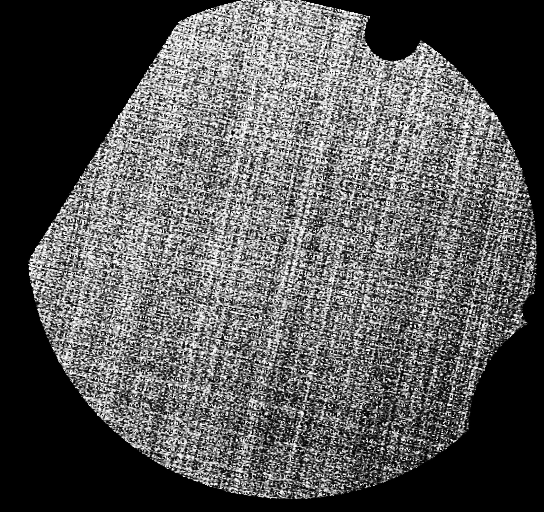

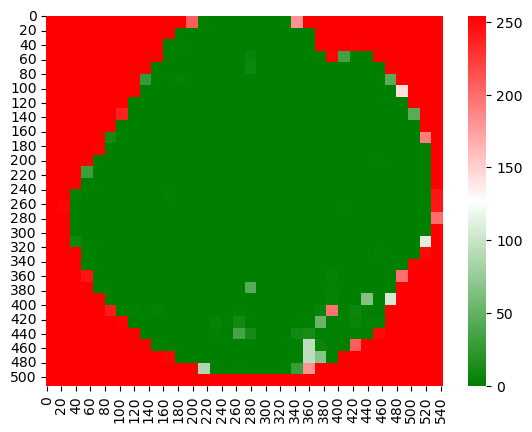

(array([181760.,   2048.,    768.,    768.,    512.,    256.,      0.,
          1536.,    512.,  90368.]),
 array([8.95355079e-09, 9.99999485e-02, 1.99999888e-01, 2.99999827e-01,
        3.99999767e-01, 4.99999706e-01, 5.99999646e-01, 6.99999585e-01,
        7.99999525e-01, 8.99999464e-01, 9.99999404e-01]),
 <BarContainer object of 10 artists>)

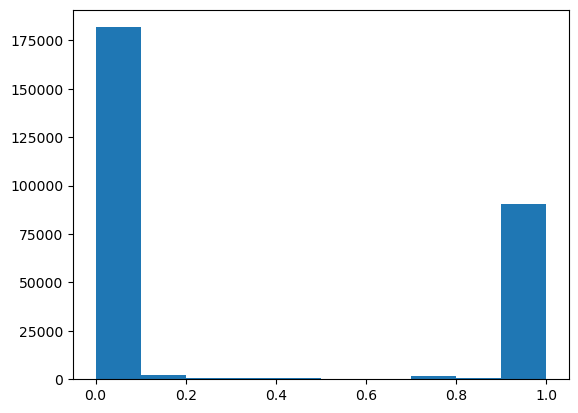

In [117]:
#load image
import random
import os
import numpy as np
from matplotlib import cm
import seaborn as sns
folder="./Images/test/clear"

a=random.choice(os.listdir(folder))


from PIL import Image
file = folder+'\\'+a
#im = Image.open("./Images/val/cloudy/asiva202302042354_rot180.png")
im = Image.open(file)
#find probe locations
size = 8 #side length of kernel from center. 16x16 for size=8
maxSqrSize = 145 #length from center to edge
midx = 280
midy = 252

#imc = im.crop((midx-maxSqrSize, midy-maxSqrSize, midx+maxSqrSize, midy+maxSqrSize))
imc = im
#x_locs = np.arange(size, maxSqrSize*2 - size, size * 2)
x_locs = np.arange(size, 544, size * 2)
#y_locs = np.arange(size, maxSqrSize*2 - size, size * 2)
y_locs = np.arange(size, 512, size * 2)

#heatmap = np.empty([maxSqrSize*2 - (maxSqrSize*2 % (size*2)), maxSqrSize*2 - (maxSqrSize*2 % (size*2))])
heatmap = np.empty([512, 544])
for y in y_locs:
    for x in x_locs:
        imk = imc.crop((x-size, y-size, x+size, y+size))
        imk.save("tmp.png")
        img = keras.utils.load_img("tmp.png", target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array, verbose = 0)
        score = float(predictions[0])

        clear_score = (1 - score)
        cloudy_score = score
        for k_y in range(y-size, y+size):
            for k_x in range(x-size, x+size):
                heatmap[k_y, k_x] = cloudy_score
imc_heatmap = Image.fromarray(np.uint8(heatmap*255))
display(imc)
plt.figure()
from  matplotlib.colors import LinearSegmentedColormap
cm=LinearSegmentedColormap.from_list('gr',["r", "w", "g"], N=256).reversed()
sns.heatmap(imc_heatmap, cmap=cm)
plt.show()
counts, bins = np.histogram(heatmap)
plt.hist(bins[:-1], bins, weights=counts)

In [118]:
#create mask based on a clear image. Filter out edges of the image
high_mask = np.where(heatmap > 0.9, True, False)
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
#count = 0
#for i in range(len(heatmap_masked)):
#    for j in range(len(heatmap_masked)):
#        if(heatmap_masked[i, j] > 0.9):
#            count += 1
avg_val = np.mean(heatmap)
avg_val_filtered = np.mean(heatmap_filtered)
print("No mask average: " + str(avg_val))
print("Filtered image average: " + str(avg_val_filtered))



No mask average: 0.3344837589394532
Filtered image average: 0.015358693678721419


(array([2.78527e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.07123423, 0.14246845, 0.21370268, 0.2849369 ,
        0.35617113, 0.42740536, 0.49863958, 0.56987381, 0.64110804,
        0.71234226]),
 <BarContainer object of 10 artists>)

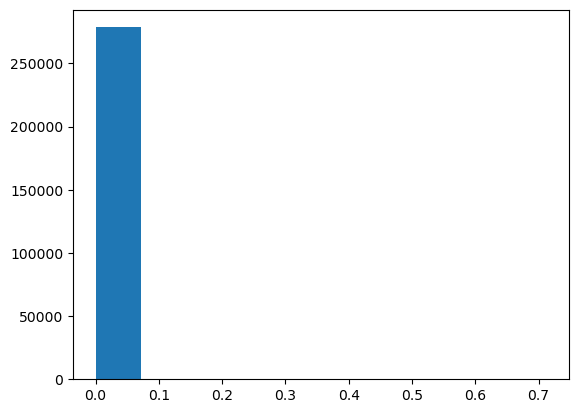

In [119]:
#apply mask to create a more accurate histogram
#add nonmasked values to flattened array
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
vals = np.empty(544 * 512)
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #add pixel value to vals
            vals[-1] = tmp[i, j]

counts, bins = np.histogram(vals)
plt.hist(bins[:-1], bins, weights=counts)

In [120]:
#calculate percentage cloud coverage. Iterate through image 
#and for a given threshold value set value above to 1 and values below to 0 then average the array
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
th = 0.3
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
cloud_count = 0
total = 0
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #increment
            total += 1
            if(tmp[i, j] >= th):
                cloud_count += 1
        
print("percentage cloud coverage = " + str(cloud_count / total))


percentage cloud coverage = 0.01904761904761905


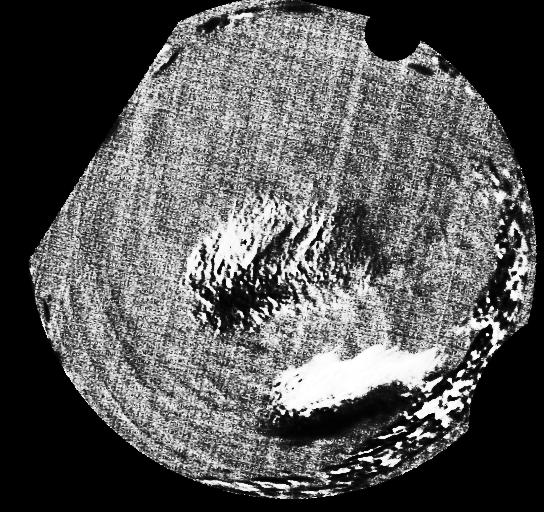

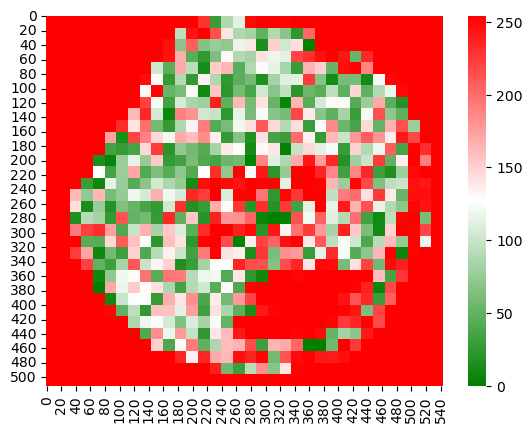

(array([ 15360.,  23040.,  17920.,  16896.,  17920.,  17152.,  12800.,
          8960.,  13568., 134912.]),
 array([4.21530043e-04, 1.00379317e-01, 2.00337105e-01, 3.00294892e-01,
        4.00252680e-01, 5.00210467e-01, 6.00168254e-01, 7.00126042e-01,
        8.00083829e-01, 9.00041617e-01, 9.99999404e-01]),
 <BarContainer object of 10 artists>)

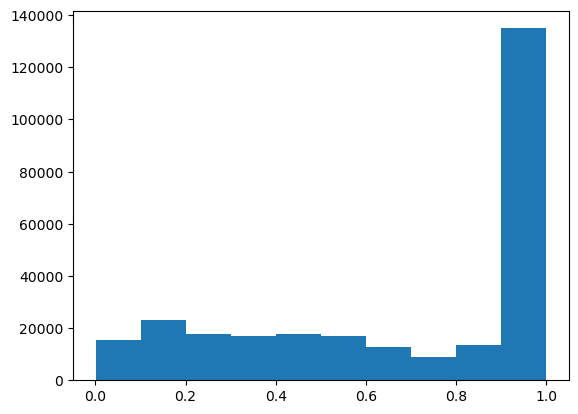

In [125]:
#apply to cloudy image

#load image
import random
import os
import numpy as np
from matplotlib import cm
import seaborn as sns
folder="./Images/test/cloudy"

a=random.choice(os.listdir(folder))


from PIL import Image
file = folder+'\\'+a
im = Image.open("./Images/val/cloudy/asiva202302042354_rot180.png")
#m = Image.open(file)
#find probe locations
size = 8 #side length of kernel from center. 16x16 for size=8
maxSqrSize = 145 #length from center to edge
midx = 280
midy = 252

#imc = im.crop((midx-maxSqrSize, midy-maxSqrSize, midx+maxSqrSize, midy+maxSqrSize))
imc = im
#x_locs = np.arange(size, maxSqrSize*2 - size, size * 2)
x_locs = np.arange(size, 544, size * 2)
#y_locs = np.arange(size, maxSqrSize*2 - size, size * 2)
y_locs = np.arange(size, 512, size * 2)

#heatmap = np.empty([maxSqrSize*2 - (maxSqrSize*2 % (size*2)), maxSqrSize*2 - (maxSqrSize*2 % (size*2))])
heatmap = np.empty([512, 544])
for y in y_locs:
    for x in x_locs:
        imk = imc.crop((x-size, y-size, x+size, y+size))
        imk.save("tmp.png")
        img = keras.utils.load_img("tmp.png", target_size=image_size)
        img_array = keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array, verbose = 0)
        score = float(predictions[0])

        clear_score = (1 - score)
        cloudy_score = score
        for k_y in range(y-size, y+size):
            for k_x in range(x-size, x+size):
                heatmap[k_y, k_x] = cloudy_score
imc_heatmap = Image.fromarray(np.uint8(heatmap*255))
display(imc)
plt.figure()
from  matplotlib.colors import LinearSegmentedColormap
cm=LinearSegmentedColormap.from_list('gr',["r", "w", "g"], N=256).reversed()
sns.heatmap(imc_heatmap, cmap=cm)
plt.show()
counts, bins = np.histogram(heatmap)
plt.hist(bins[:-1], bins, weights=counts)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.49999601, 0.59999601, 0.69999601, 0.79999601, 0.89999601,
        0.99999601, 1.09999601, 1.19999601, 1.29999601, 1.39999601,
        1.49999601]),
 <BarContainer object of 10 artists>)

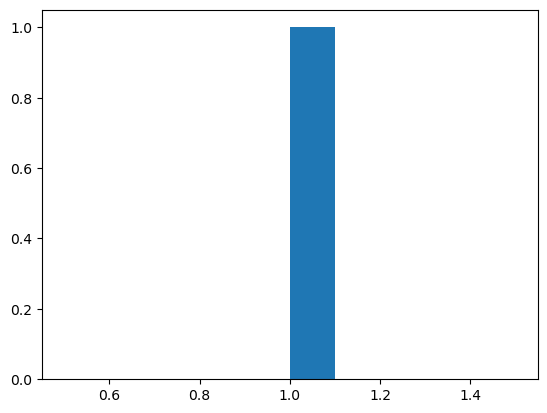

In [142]:
#apply mask to create a more accurate histogram
#add nonmasked values to flattened array
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
vals = np.zeros(544 * 512)
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #add pixel value to vals
            vals[-1] = tmp[i, j]
counts, bins = np.histogram(vals)
plt.hist(bins[:-1], bins, weights=counts)

In [130]:
#calculate percentage cloud coverage. Iterate through image 
#and for a given threshold value set value above to 1 and values below to 0 then average the array
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
th = 0.3
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
cloud_count = 0
total = 0
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #increment
            total += 1
            if(tmp[i, j] >= th):
                cloud_count += 1
        
print("percentage cloud coverage = " + str(cloud_count / total))


percentage cloud coverage = 0.7006802721088435
